In [3]:
from jw_utils import file_utils as fu
import plotly.graph_objects as go
import plotly.offline as pyo
import numpy as np
from Bio import Phylo
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from jw_utils import jw_draw_tree
import os
import json

### Read in distance matrix generated in 'dwnld_assemblies_make_distMatrix.ipynb'

In [13]:
dist_matrix_df = pd.read_csv('./dist_mat.csv').set_index('Unnamed: 0')

In [5]:
def make_phylo_distMatrix(df):
    "make a Bio.Phylo distance matrix from a lower triangle df with names set as the df.index"

    matrix = []
    names=[]
    for i, name in enumerate(df.index):
        names.append(name)
        matrix.append(list(df.iloc[i, :(i+1)]))
    return Phylo.TreeConstruction.DistanceMatrix(names=names, matrix=matrix)

In [9]:
def collapse_to_single_col(df):
    """Return 1d list of all values from lower triangle id matrix for histogram
        *diagonal ID 0 values are removed
    df (pd.DataFrame): lower triangle dataframe
    """
    one_dim_list = []
    print(f'shape: {df.shape}')
    for i, _ in enumerate(df):
        c=list(df.iloc[(i+1):, i])
        one_dim_list = one_dim_list + c
    return one_dim_list

In [17]:
def make_histogram(one_dim_list, range2 = [0.0125,0.028], bins=100):
    """Return plotly fig from one dimensional list of distances"""
    binsize = (max(range2)-min(range2))/bins

    range1 = [min(one_dim_list),min(range2)]
    range1_num_bins = int((max(range1)-min(range1))/binsize)
    range3 = [max(range2),max(one_dim_list)]
    range3_num_bins = 1

    hist_highly_similar = np.histogram(one_dim_list, range=[0,0.0125], bins=range1_num_bins )
    hist = np.histogram(one_dim_list, range=[0.0125,0.028], bins=bins)
    hist_outliers = np.histogram(one_dim_list, range=[0.028,max(one_dim_list)], bins=range3_num_bins )

    trace_highly_similar = go.Bar(x=hist_highly_similar[1], y=hist_highly_similar[0],marker_color='rgb(175,100,200)', name='highly_similar')
    trace = go.Bar(x=hist[1], y=hist[0],marker_color='rgb(15,100,200)', name='keep')
    trace_outlier = go.Bar(x=hist_outliers[1], y=hist_outliers[0], marker_color='rgb(15,150,150)', name='outliers, > 0.028')

    fig = go.Figure(data=[trace_highly_similar, trace, trace_outlier])
    fig.update_xaxes({'tickfont':
                        {'size':10},
                    'title':{
                        'text': 'minHash distance',
                        'font': {'size':15}
                        }
                    })
    fig.update_yaxes({'title':
                    {'text':'counts, distances',
                        'font':
                            {'size':15}
                        },
                    'tickfont':
                        {'size':10}
                    })
    fig.update_layout({
                    'legend':
                        {'font':
                            {'size':15}}
                    })
    return fig

#### get distribution of minHash genome distances

###### collapse distance matrix to one dimensional list

##### Make plotly histogram of distribution of genome pairwise distances

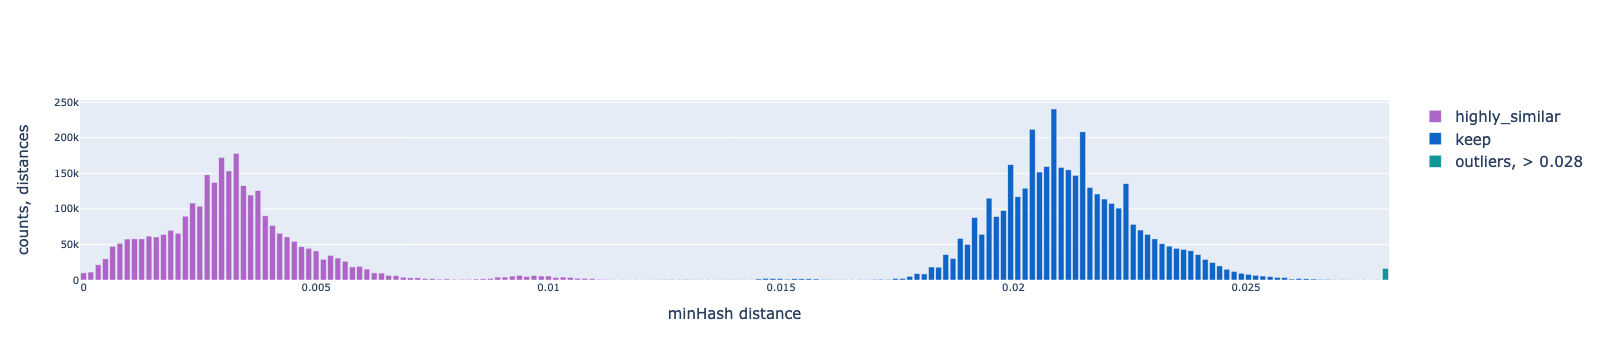

In [18]:
one_dim_list_all =  collapse_to_single_col(dist_matrix_df)
fig_all = make_histogram(one_dim_list_all, range2 = [0.0125,0.028], bins=100) 
fig_all

In [19]:
def remove_similar_genomes(df, threshold=0.006):
    """return a matrix with IDs removed that are highly similar"""

    fails = 0 
    for genome in df.index:
        df.loc[genome, genome]=np.inf
        if df.loc[genome,:].min() <= threshold:
            fails +=1
            df = df.drop([genome]) #drop row
            df = df.drop([genome], axis=1) #drop columns
    if fails !=0:
        return remove_similar_genomes(df, threshold=threshold)
    else:
        return df


In [20]:
def remove_accessions_from_df(df, outliers):
    '''return a distance matrix with outliers removed

        each df index must contain the outlier name in the beginning
        of the string
    outliers (list of other iterable): ids in df index to be removed
    '''
    for genome in df.index:
        for acc in outliers:
            if str(genome).startswith(acc):
                print(genome)
                df = df.drop([genome])
                df = df.drop([genome], axis=1)
    return df

### Remove similar genomes from analysis
Strategy:
1) For each index, determine if there are any distances in that row that are below threshold similarity value. 
2) If there is a similarity value below threshold then remove entire row, and corresponding column to create a new matrix. 
repeat above steps on new matrix

In [23]:
df_distmat_003 = remove_similar_genomes(dist_matrix_df, threshold=0.003)
dm_003 = make_phylo_distMatrix(df_distmat_003)

### Make neighbor joining tree from deduped distance matrix

In [24]:
if not os.path.exists('./nj_trees'):
    os.makedirs('./nj_trees')
constructor = DistanceTreeConstructor()
tree_003 = constructor.nj(dm_003)
Phylo.write(tree_003, format='newick', file='./nj_trees/tree_003.nwk')

1

### remove outliers  
for each assembly, get the average distance from all other leaves and plot the distribution

In [65]:
df_distmat_003
ave_distance = {}
for ass in df_distmat_003.index:
    row_distances_f = df_distmat_003.loc[ass,:] < np.inf
    col_distances_f = df_distmat_003.loc[:,ass] < np.inf
    col = df_distmat_003.loc[col_distances_f, ass]
    row = df_distmat_003.loc[ass, row_distances_f]
    tot_distance = col+row
    ave = (col.sum()+row.sum())/(df_distmat_003.shape[0]-1)
    ave_distance[ass] = ave



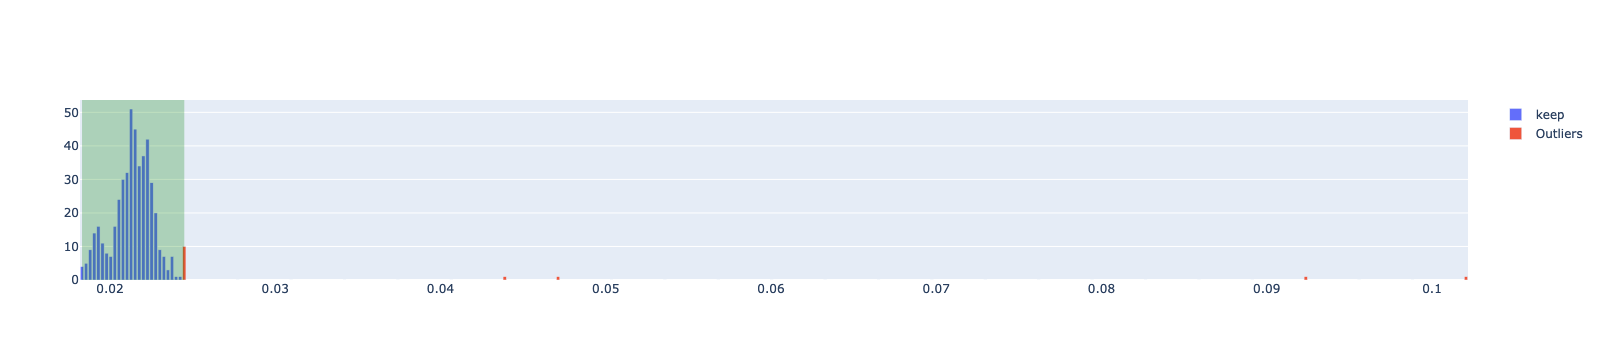

In [87]:
threshold = 0.0245
lower = min(list(ave_distance.values()))
upper = max(list(ave_distance.values()))
outliers = [acc for acc, dist in list(ave_distance.items()) if dist>threshold]
y,x = np.histogram(list(ave_distance.values()), range = [lower,threshold], bins = 25)
y_out, x_out = np.histogram(list(ave_distance.values()), range = [threshold, upper], bins = 25)
trace = go.Bar(x=x, y=y, name = 'keep')
trace_out = go.Bar(x=x_out, y=y_out, name = 'Outliers')
ave_tree_dist_fig = go.Figure(data=[trace, trace_out])
ave_tree_dist_fig.add_vrect(lower,threshold, fillcolor="green", opacity=0.25, line_width=0)

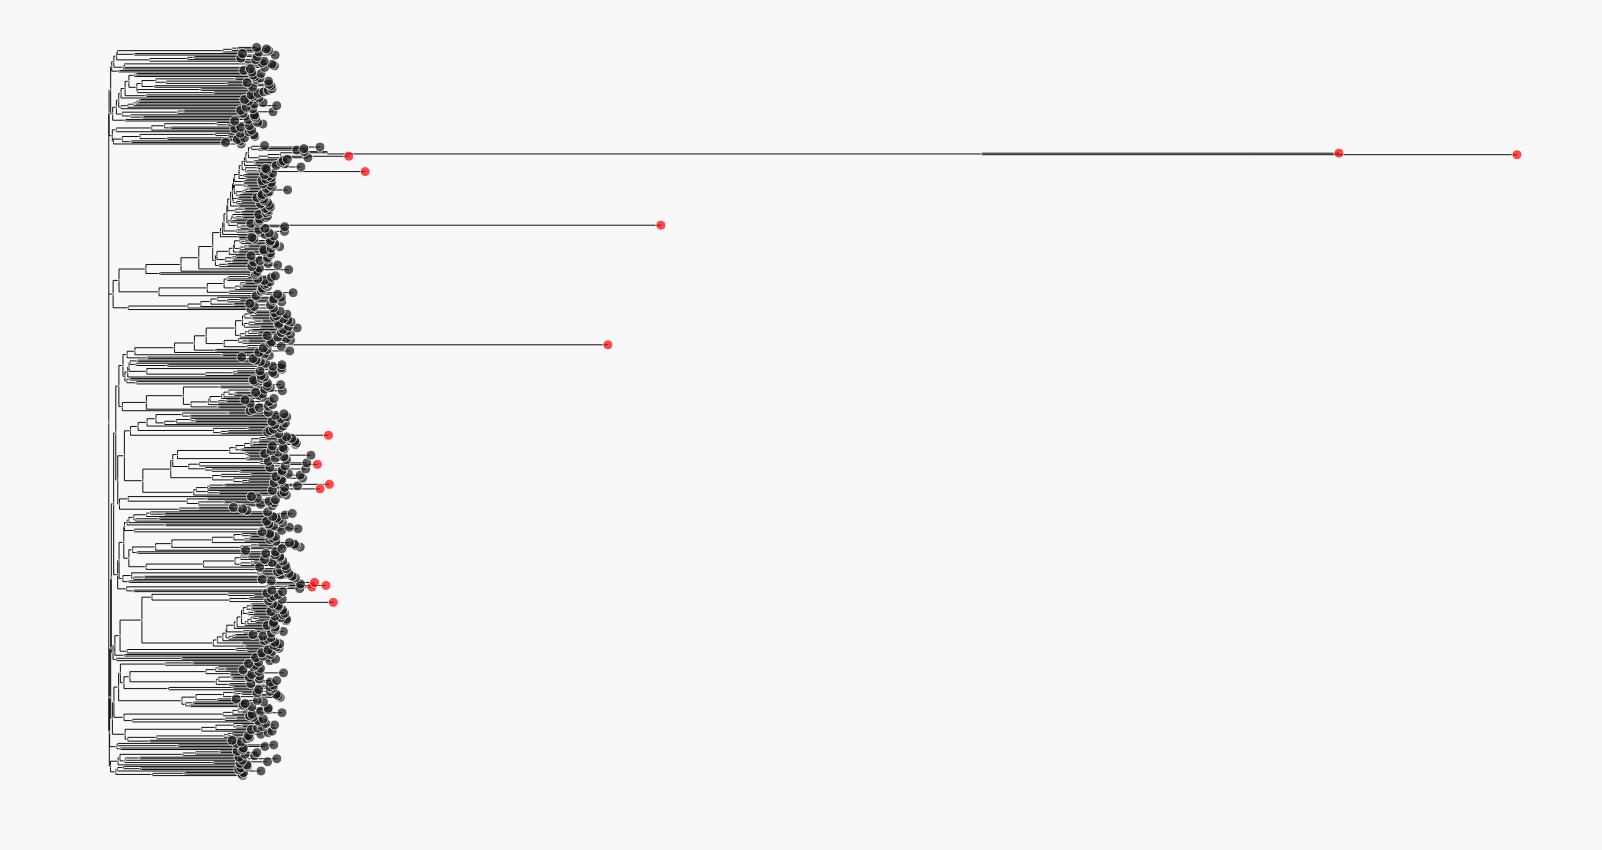

In [85]:
node_color_dict = {acc:'red' for acc in outliers}
tree_003_outliers = jw_draw_tree.create_tree(tree_003, node_color_dict=node_color_dict)
go.Figure(tree_003_outliers)

### Final tree, from deduped distance matrix with outlier leaves removed

GCF_024589135.1
GCF_008931365.1
GCF_012974585.1
GCF_000682435.1
GCF_003812065.1
GCF_012974845.1
GCF_011683475.1
GCF_005785665.1
GCF_019903235.1
GCF_012952675.1
GCF_022342105.1
GCF_000969465.1
GCF_904885815.1
GCF_001861735.1


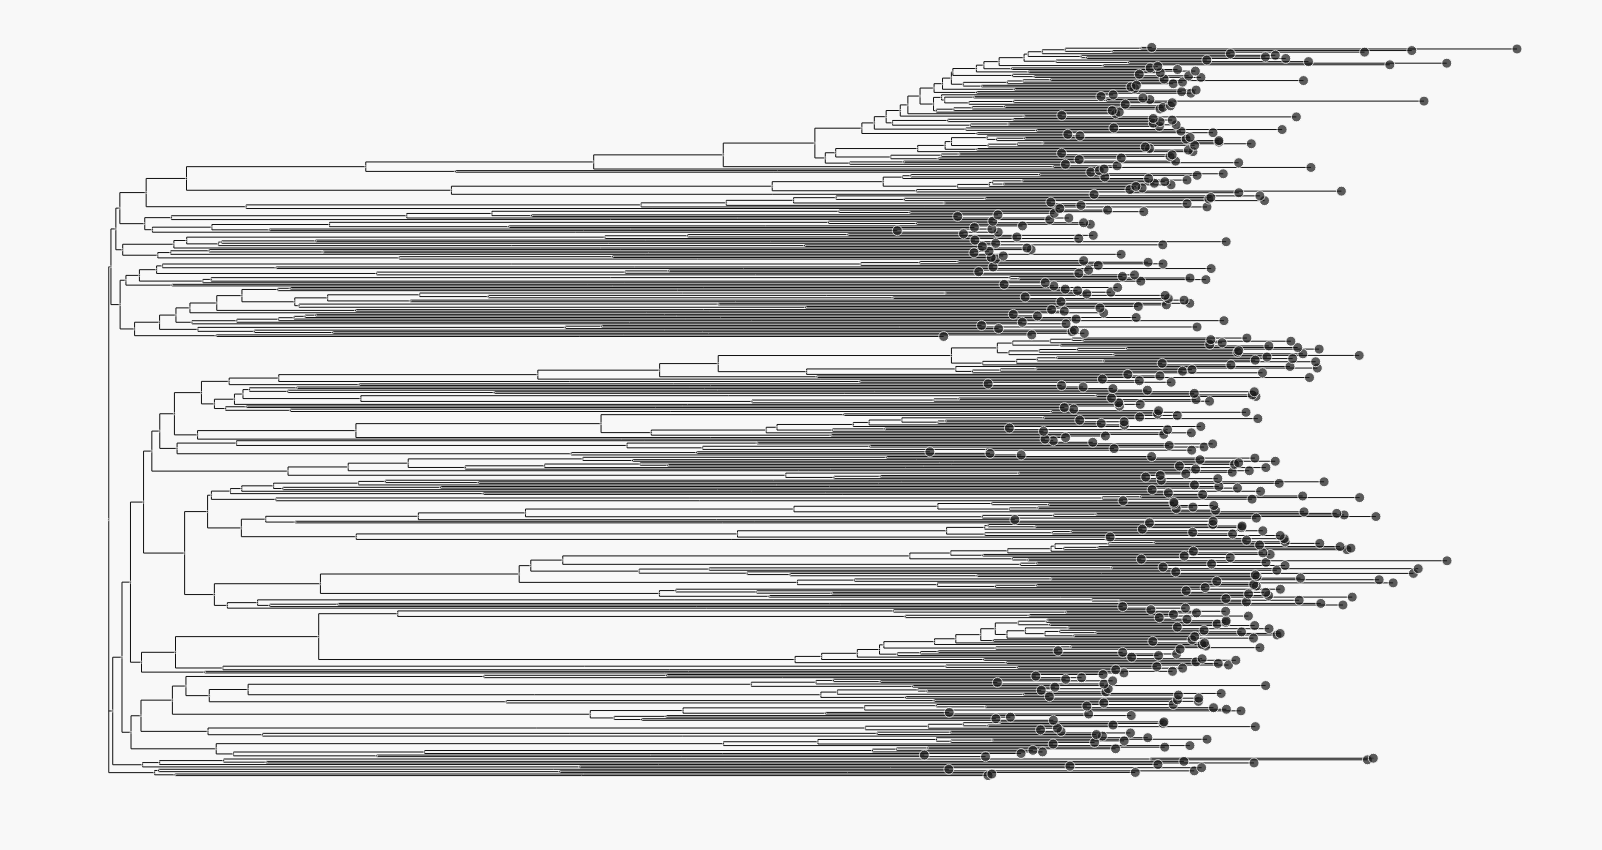

In [88]:
df_distmat_003_no_outs = remove_accessions_from_df(df_distmat_003, outliers=outliers)
dm_003_no_outs = make_phylo_distMatrix(df_distmat_003_no_outs)
tree_003_no_outs = constructor.nj(dm_003_no_outs)
Phylo.write(tree_003_no_outs, format='newick', file='./nj_trees/tree_003.nwk')
tree_003_no_outs_fig = jw_draw_tree.create_tree(tree_003_no_outs, node_color_dict=node_color_dict)
go.Figure(tree_003_no_outs_fig)

shape: (462, 462)


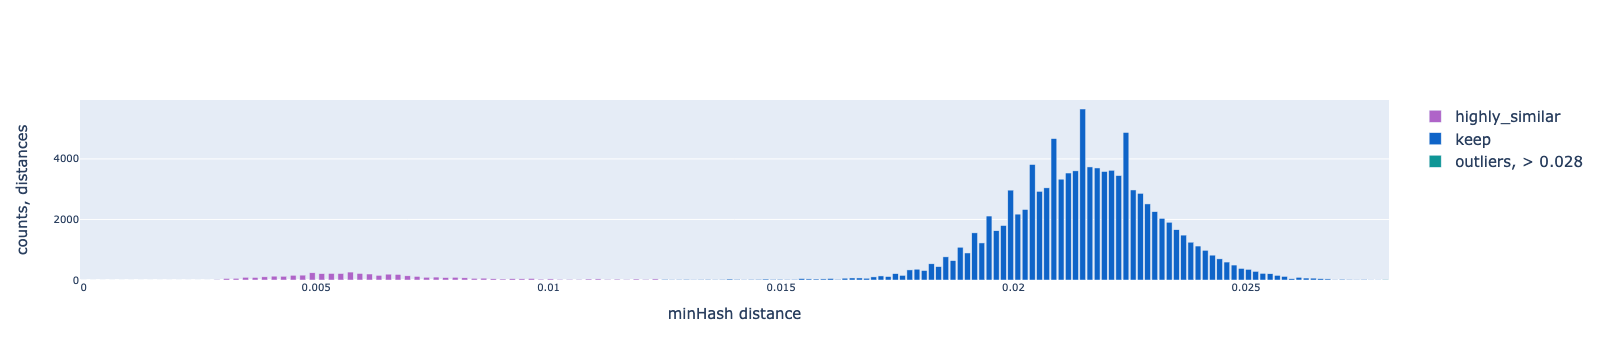

In [89]:
make_histogram(collapse_to_single_col(df_distmat_003_no_outs))

#### get final accessions for reciprical blast duplication analysis

In [90]:
df_distmat_003_no_outs.shape
accessions = [acc[:15] for acc in list(df_distmat_003_no_outs.index)]
with open('./deduped_accessions.txt', 'w') as f:
    for acc in accessions:
        f.write(acc+'\n')

'temp-plot.html'